# Experiments 2. Quadratic Programming

Minimization of function

$$f(x)=\sum\limits_{i=k}^N d_i x_i^2$$
for positive $d_i$.

In [1]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax.config import config
%matplotlib inline

In [2]:
from methods import gradf_inexact
from methods import GradientDescent, parse_logs
from methods import ConstantStepSize

In [3]:
matplotlib.use('Agg')
params = {'legend.fontsize': 20,
          'legend.handlelength': 4,
          "axes.labelsize": 45,
          "xtick.labelsize": 25,
          "ytick.labelsize": 25,
          "lines.linewidth": 2,
           "axes.titlesize":30}
matplotlib.rcParams.update(params)

In [4]:
config.update("jax_enable_x64", True)

In [5]:
path_pics = "../pics/"

In [6]:
def f1(x, A):
    m = A.shape[0]
    r = A@x
    return 1/2 * x.T @ A @ x

gradf = jax.grad(f1, argnums=0, has_aux=False)
jit_gradf = jax.jit(gradf)

## 1. Comparison of Theoretical Iterations Count and Practice

In [7]:
np.random.seed(1)
n = 100
k = 10
mu = 0.1
d = np.zeros(n)
d[:k] *= 0
d[k:] = np.linspace(mu, 1, n-k)
A = np.diag(d)
w = np.random.randn(n)

In [8]:
eigvals, _ = np.linalg.eigh(A)
eigvals.sort()
L = np.real(eigvals.max())
mu = eigvals[eigvals>=1e-12].min()
L, mu

(1.0, 0.1)

In [9]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, A).block_until_ready())
f = lambda x: f1(x, A)

In [10]:
w = np.random.randn(n)
f(np.zeros(A.shape[-1]))

0.0

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [11]:
np.random.seed(1)
np.random.seed(1)
n = 100
k = 10
mu_list = [0.01, 0.1, 0.9, 0.99]
res = {mu:{"delta":[], "iters":[], "N":[]} for mu in mu_list}
for mu in mu_list:
    d = np.zeros(n)
    d[:k] *= 0
    d[k:] = np.linspace(mu, 1, n-k)
    A = np.diag(d)
    w = np.random.randn(n)
    sigma=0
    eigvals, _ = np.linalg.eigh(A)
    eigvals.sort()
    L = np.real(eigvals.max())
    mu = eigvals[eigvals>=1e-12].min()
    L, mu
    print(mu)
    gradf = lambda x: np.array(jit_gradf(x, A).block_until_ready())
    f = lambda x: f1(x, A)
    f(np.zeros(A.shape[-1]))
    alpha = 1/L
    w = np.ones(n)*100
    v = np.random.randn(*w.shape)
    Delta_list = [1e-7, 1e-4, 1e-1]
    N = int(2e4)
    save_iter = int(1)
    tol = 1e-9
    methods = []
    for Delta in Delta_list:
        tol = np.sqrt(6)*Delta
        if Delta > 0:
            N_star = int(L/mu * np.log(mu*f(w)/(6*Delta**2)) + 0.5)
        else:
            N_star = np.inf
        grad_inexact = lambda w: gradf_inexact(w, gradf, Delta, 1, v=v)
        method = GradientDescent(ConstantStepSize(alpha), name="GD, Delta={}".format(Delta), save_iter=save_iter)
        x = method.solve(w, f, grad_inexact, tol=tol, max_iter=N)
        print("\t{}\t{}\t{}\t{:.2f}".format(Delta, len(method.history), N_star, N_star/len(method.history)))
        methods.append(method)
        res[mu]["delta"].append(int(np.log10(Delta)))
        res[mu]["iters"].append(len(method.history))
        res[mu]["N"].append(N_star)

0.01
	1e-07	1528	3817	2.50
	0.0001	841	2436	2.90
	0.1	155	1054	6.80
0.1
	1e-07	169	406	2.40
	0.0001	104	267	2.57
	0.1	40	129	3.23
0.9
	1e-07	10	48	4.80
	0.0001	8	33	4.12
	0.1	5	17	3.40
0.99
	1e-07	6	44	7.33
	0.0001	5	30	6.00
	0.1	3	16	5.33


In [12]:
s = ""
for mu in mu_list:
    s += str(mu) + " & "
    cur_list = ["$10^{{{}}}$".format(i) for i in res[mu]["delta"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    cur_list = ["${}$".format(i) for i in res[mu]["iters"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}&"
    cur_list = ["${}$".format(i) for i in res[mu]["N"]]
    s+= "\\begin{tabular}{@{}c@{}} " + " \\\\ ".join(cur_list) + " \\end{tabular}"
    s+= "\\\\\n\\hline\n"
print(s)

0.01 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $1528$ \\ $841$ \\ $155$ \end{tabular}&\begin{tabular}{@{}c@{}} $3817$ \\ $2436$ \\ $1054$ \end{tabular}\\
\hline
0.1 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $169$ \\ $104$ \\ $40$ \end{tabular}&\begin{tabular}{@{}c@{}} $406$ \\ $267$ \\ $129$ \end{tabular}\\
\hline
0.9 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $10$ \\ $8$ \\ $5$ \end{tabular}&\begin{tabular}{@{}c@{}} $48$ \\ $33$ \\ $17$ \end{tabular}\\
\hline
0.99 & \begin{tabular}{@{}c@{}} $10^{-7}$ \\ $10^{-4}$ \\ $10^{-1}$ \end{tabular}&\begin{tabular}{@{}c@{}} $6$ \\ $5$ \\ $3$ \end{tabular}&\begin{tabular}{@{}c@{}} $44$ \\ $30$ \\ $16$ \end{tabular}\\
\hline



## 2. Trajectory Visualisation for Different Noise Types

In [13]:
def f1(x, A):
    m = A.shape[0]
    r = A@x
    return 1/2 * x.T @ A @ x

gradf = jax.grad(f1, argnums=0, has_aux=False)
jit_gradf = jax.jit(gradf)

In [14]:
np.random.seed(1)
n = 2
k = 1
d = np.array([0, 1])
A = np.diag(d)
w = np.random.randn(n)

In [15]:
eigvals, _ = np.linalg.eigh(A)
eigvals.sort()
L = np.real(eigvals.max())
mu = eigvals[eigvals>=1e-12].min()
L, np.linalg.norm(w), mu

(1.0, 1.7357257185673867, 1.0)

In [16]:
sigma=0
gradf = lambda x: np.array(jit_gradf(x, A).block_until_ready())
f = lambda x: f1(x, A)

In [17]:
w = np.random.randn(n)
f(np.zeros(A.shape[-1]))

0.0

The case when $\xi \sim \mathcal{U}(S_1(0))$

In [20]:
np.random.seed(1)
alpha = 1/L
#alpha = 1e-1
w = np.ones(n)
v = np.ones(n)
Delta_list = [0, 1e-12]
N = int(500)
save_iter = int(1)
tol = 0
methods = []
Delta = 1e-6

Delta = 0
tol = np.sqrt(6)*Delta
method = GradientDescent(ConstantStepSize(alpha), name="Exact", save_iter=save_iter)
x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, 4, v=v), tol=tol, max_iter=N)
print(Delta, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history), x)
methods.append(method)
Delta = 1e-1
grad_name = {1:"random inexactness",3:"-gradient",4:"constant inexactness",}
for dtype in [1,3,4]:
    tol = np.sqrt(6)*Delta
    method = GradientDescent(ConstantStepSize(alpha), name="{}".format(grad_name[dtype]), save_iter=save_iter)
    x = method.solve(w, f, lambda w: gradf_inexact(w, gradf, Delta, dtype, v=v), tol=tol, max_iter=N)
    print(dtype, np.linalg.norm(gradf(x)), f(x), np.linalg.norm(x), len(method.history), x)
    methods.append(method)

0 0.0 0.0 1.0 2 [1. 0.]
1 0.0936017189039311 0.004380640890885266 0.96933438096519 2 [0.96480457 0.09360172]
3 0.09999999999999998 0.0049999999999999975 1.004987562112089 2 [1.  0.1]
4 0.07071067811865483 0.0025000000000000057 0.9319756669370132 2 [ 0.92928932 -0.07071068]


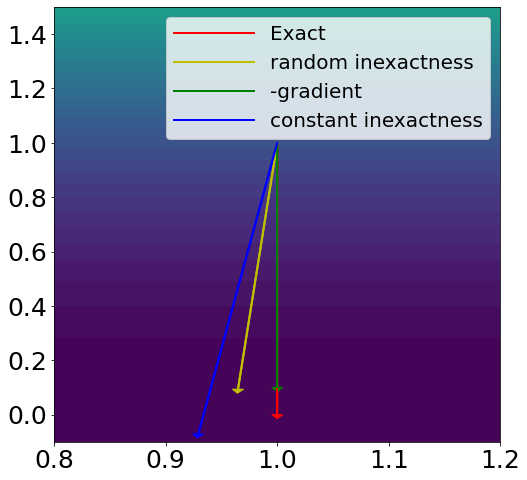

In [21]:
%matplotlib inline
l = 100
x, y = np.mgrid[-l:l,
                -l:l]
x = x / 50
y = y/50
z = np.zeros((2*l, 2*l))
for i in range(2*100):
    for j in range(2*100):
        z[i, j] = f(np.array([x[i, j], y[i, j]]))
#z = np.log(z+1e-16)+16
fig, ax = plt.subplots()
ax.contourf(x, y, z, levels=50)


color = ["r", "y", "green", "b"]
for indm, method in enumerate(methods):
    xhistory = method.history
    x_list = np.array([x for x, _ in xhistory])
    plt.plot(x_list[:, 0], x_list[:, 1], color=color[indm], label=method.name)
    for ind in range(len(x_list)-1):
        x, y = x_list[ind, 0], x_list[ind,1]
        dx, dy = x_list[ind+1, 0] - x_list[ind, 0], x_list[ind+1,1] - x_list[ind,1]
        if ind % 1 == 0:
            head_width=0.01
        else:
            head_width=0
        ax.arrow(x, y, dx, dy, color=color[indm], head_width=head_width)
plt.legend()
fig.set_figwidth(8)    #  ширина и
fig.set_figheight(8)    #  высота "Figure"

plt.xlim(.8, 1.2)
plt.ylim(-0.1, 1.5)
plt.savefig(os.path.join(path_pics, "lines.png"))